In [1]:
import matplotlib.pyplot as plt
import pandas as pd
# Bar plot with these error bars 
# Mean for each count + 95% CI based on standard error 

In [2]:
max_N = 5
weighted=True 
out_folder = '../outputs/model_N{}{}/'.format(max_N, '_weighted' if weighted else '')
mc_results = pd.read_csv(out_folder + 'monte_carlo.csv')
mc_results.head()

,random,trial_label,scenario,num_firms,count
0,8915,typical_business,original,0,225
1,8915,typical_business,original,1,82
2,8915,typical_business,original,2,69
3,8915,typical_business,original,3,10
4,8915,typical_business,original,4,65


In [13]:
original = mc_results[(mc_results.trial_label == 'typical_business') & (mc_results.scenario == 'original')]
original = original[['random','num_firms','count']]
mc_diff = pd.merge(mc_results[mc_results.scenario == 'adjusted'], original, on=['random','num_firms'], suffixes=('_adj','_orig'))
mc_diff['diff'] = mc_diff['count_adj'] - mc_diff['count_orig']
mc_diff.head()

,random,trial_label,scenario,num_firms,count_adj,count_orig,diff
0,8915,typical_business,adjusted,0,228,225,3
1,8915,one_percent,adjusted,0,230,225,5
2,8915,five_percent,adjusted,0,245,225,20
3,8915,typical_business,adjusted,1,82,82,0
4,8915,one_percent,adjusted,1,85,82,3


In [28]:
overall_sum = mc_diff.copy()
for field in ['count_adj','count_orig','diff']:
    overall_sum[field] = overall_sum[field] * overall_sum['num_firms']
overall_sum = overall_sum.groupby(['random','trial_label']).sum().reset_index()
overall_sum['num_firms'] = 'total'

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18278/681293090.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  overall_sum = overall_sum.groupby(['random','trial_label']).sum().reset_index()


In [37]:
sum_adj = overall_sum[['random','trial_label','count_adj']]
sum_adj['count'] = sum_adj['count_adj']
sum_adj['scenario'] = sum_adj['trial_label']
sum_orig = overall_sum[['random','trial_label','count_orig']]
sum_orig['count'] = sum_orig['count_orig']
sum_orig['scenario'] = 'original'
to_plot = pd.concat([sum_orig, sum_adj])

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18278/182174507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_adj['count'] = sum_adj['count_adj']
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18278/182174507.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sum_adj['scenario'] = sum_adj['trial_label']
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18278/182174507.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [63]:
overall_sum.groupby(['trial_label']).mean()

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_18278/3966684711.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  overall_sum.groupby(['trial_label']).mean()


,random,count_adj,count_orig,diff
trial_label,,,,
five_percent,4863.17,737.55,859.91,-122.36
one_percent,4863.17,833.47,859.91,-26.44
typical_business,4863.17,853.61,859.91,-6.30


In [64]:
overall_sum.head()

,random,trial_label,num_firms,count_adj,count_orig,diff
0,3,five_percent,total,666,751,-85
1,3,one_percent,total,725,751,-26
2,3,typical_business,total,748,751,-3
3,10,five_percent,total,642,735,-93
4,10,one_percent,total,721,735,-14


In [68]:
import scipy.stats as stats
def get_ttest(x,y):
    return stats.ttest_ind(x, y, equal_var=False).pvalue

thing = overall_sum.groupby('trial_label').apply(lambda dfx: get_ttest(
    dfx['count_adj'],
    dfx['count_orig']))
thing

trial_label
five_percent        2.676774e-15
one_percent         6.103031e-02
typical_business    6.585619e-01
dtype: float64

In [70]:
thing['typical_business']

0.6585619242525876

Text(0, 0.5, 'Predicted Number of Firms')

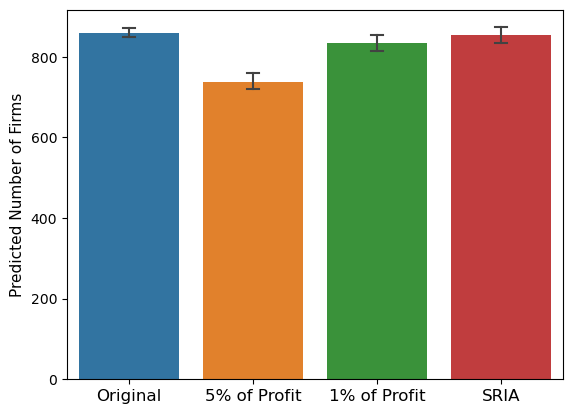

In [50]:
fig, ax = plt.subplots()
sns.barplot(data=to_plot, x='scenario', y='count', ax=ax, capsize=0.1, errwidth=1.5)
import numpy as np
plt.xticks(np.arange(4), [r'Original', '5% of Profit', '1% of Profit', 'SRIA'],
                  fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('Predicted Number of Firms', fontsize=11)

Text(0.5, 0, 'Number of Firms per Market')

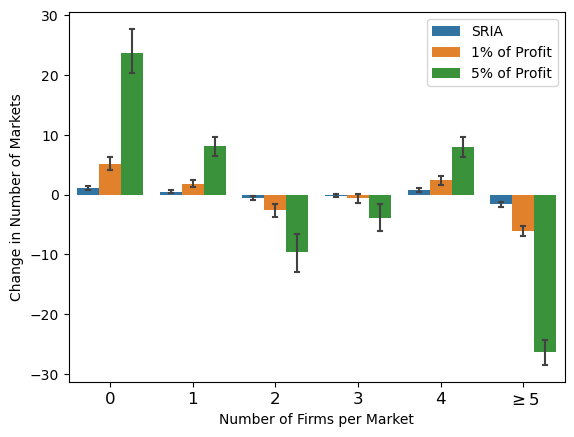

In [60]:
import seaborn as sns
fig, ax = plt.subplots()
mc_diff['Counterfactual'] = [['SRIA','1% of Profit', '5% of Profit']\
                             [['typical_business','one_percent','five_percent'].index(x)]\
                             for x in mc_diff.trial_label]
sns.barplot(data=mc_diff, x='num_firms', y='diff', hue='Counterfactual', capsize=0.05, errwidth=1.5, ax=ax)
plt.legend()
ax.set_ylabel('Change in Number of Markets')
plt.xticks(np.arange(6), [r'0', '1', '2', '3', '4','$\geq $5'],
                  fontsize=12);
ax.set_xlabel('Number of Firms per Market')

In [5]:
mc_results.groupby(['trial_label','scenario', 'num_firms']).std()
sns.barplot(data=df, x="island", y="body_mass_g", hue="sex")

random      count
trial_label      scenario num_firms                        
five_percent     adjusted 0          2962.111576  32.508676
                          1          2962.111576  16.133693
                          2          2962.111576  34.809698
                          3          2962.111576  19.762926
                          4          2962.111576  16.481820
                          5          2962.111576  17.801541
                 original 0          2962.111576  36.762547
                          1          2962.111576  15.104765
                          2          2962.111576  42.685198
                          3          2962.111576  22.677758
                          4          2962.111576  16.355890
                          5          2962.111576  20.621544
one_percent      adjusted 0          2962.111576  35.111900
                          1          2962.111576  15.647312
                          2          2962.111576  40.514393
                          3          2962.111576  21.521638
                          4          2962.111576  16.636491
                          5          2962.111576  19.874607
                 original 0          2962.111576  36.762547
                          1          2962.111576  15.104765
                          2          2962.111576  42.685198
                          3          2962.111576  22.677758
                          4          2962.111576  16.355890
                          5          2962.111576  20.621544
typical_business adjusted 0          2962.111576  36.346258
                          1          2962.111576  15.188100
                          2          2962.111576  42.076342
                          3          2962.111576  22.831256
                          4          2962.111576  16.545850
                          5          2962.111576  20.391370
                 original 0          2962.111576  36.762547
                          1          2962.111576  15.104765
                          2          2962.111576  42.685198
                          3          2962.111576  22.677758
                          4          2962.111576  16.355890
                          5          2962.111576  20.621544